# Models

## Imports

In [1]:
import os
import sys

sys.path.append(os.getcwd())
os.chdir("../..")

import pandas as pd
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 300)

In [2]:
import dill
import numpy as np
import matplotlib.pyplot as plt

import h2o
from h2o.automl import H2OAutoML

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, RocCurveDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression

import lightgbm as lgbm
from inference_model.preprocessing.scaler import scaler_mapper 
from inference_model.training.utils import predict_cls_lgbm_from_raw, predict_proba_lgbm_from_raw
from inference_model.preprocessing.label_encoder import LabelEncoder
import ast
# import tracemalloc
# import warnings
# from typing import Optional, Dict
# tracemalloc.start()

# Dataset

In [3]:
valid_size = 0.2
test_size = 0.5
random_state = 1
test_n_valid_combined = True

In [4]:
# 1. get/create some example data
with open("data/log_tiguan_27_mar_dac.txt") as f:
    data = ast.literal_eval(f.read())

df_pd = pd.DataFrame()
for data_value in data: 
    temp_df = pd.DataFrame(data_value[list(data_value)[0]]).sort_values(by="ts_millis:", ascending=True)["value"]
    temp_df.rename(list(data_value)[0], inplace=True)
    df_pd = pd.concat([df_pd, temp_df], axis = 1) 

df_pd.dropna(inplace=True)
df_pd["class"] = 0
df_pd["car_id"] = "123abc"
df_pd.loc[:100, ["class"]] = 1
df_pd.loc[:100, ["engine_load"]] = 100

df_pd.head()

,engine_load,engine_coolant_temp,engine_speed,vehicle_speed,intake_air_temp,maf,throttle_position,fuel_rg_pressure,barometric_pressure,control_voltage,class,car_id
0,100.0,17.0,904.5,0.0,10.0,12.55,83.14,37270.0,101.0,0.06,1,123abc
1,100.0,17.0,906.0,0.0,11.0,12.36,83.14,37800.0,101.0,14.56,1,123abc
2,100.0,17.0,905.0,0.0,10.0,12.36,83.53,37800.0,101.0,14.68,1,123abc
3,100.0,18.0,905.5,0.0,11.0,12.30,83.53,37800.0,101.0,14.72,1,123abc
4,100.0,18.0,907.0,0.0,11.0,12.47,83.14,36740.0,101.0,14.72,1,123abc


In [8]:
target_col = "class"
id_cols = ["car_id"]
cat_cols = []
cont_cols = df_pd.drop(columns=id_cols + cat_cols + [target_col]).columns.values.tolist()
df_pd[cat_cols] = df_pd[cat_cols].astype(str)

check possible class imbalance

In [9]:
df_pd[target_col].value_counts()

class
0    934
1    101
Name: count, dtype: int64

# Preprocessing
* divide dataset into train, test, valid
* scale continuous columns by standard scaler(not needed for LightGBM but for other mdoels...)

In [10]:
df_train, df_valid = train_test_split(df_pd, test_size=valid_size, stratify=df_pd[target_col], random_state=random_state)
df_valid, df_test = train_test_split(df_valid, test_size=test_size, stratify=df_valid[target_col], random_state=random_state)

df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

scaler_mapper_def = {
    "cont_cols": StandardScaler,
    "cat_cols": None,
    "id_cols": None,
}
scaler = scaler_mapper(
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    id_cols=[target_col] + id_cols,
    scaler_mapper_def=scaler_mapper_def,
)

df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)
df_valid_scaled = scaler.transform(df_valid)

## Logistic Regression

In [11]:
LR_clf = LogisticRegression(class_weight="balanced")
LR_clf.fit(df_train_scaled.drop(columns=[target_col] + id_cols + cat_cols), df_train_scaled[target_col])
LR_predicted = LR_clf.predict(df_test_scaled.drop(columns=[target_col]+ id_cols + cat_cols))

print("LR classification report :\n" + str(classification_report(df_test_scaled[target_col], LR_predicted)))

LR classification report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00        10

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



In [12]:
# which metrics am I focusing on? it is more importan to precisely predict non spenders or spenders?
from sklearn.metrics import f1_score
criterion = f1_score

threshold_score = []
for t in np.arange(0.2, 0.8, 0.01):
    # preds_bin = [int(p > t) for p in y_pred]
    preds_bin = (LR_clf.predict_proba(df_test_scaled.drop(columns=[target_col]+ id_cols + cat_cols))[:,1] >= t).astype(int)
    threshold_score.append((t, criterion(df_test_scaled[target_col], preds_bin, average="weighted")))

threshold_score = sorted(threshold_score, key=lambda x: x[1], reverse=True)
best_threshold, best_score = threshold_score[0][0], threshold_score[0][1]

print(f"The best threshold\n{best_threshold}\n, with score:\n{best_score}")

The best threshold
0.2
, with score:
1.0


In [13]:
y_onehot_test = pd.get_dummies(df_test_scaled[target_col]).values
y_score = LR_clf.predict_proba(df_test_scaled.drop(columns=[target_col]+ id_cols + cat_cols))

micro_roc_auc_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    average=None,
)

micro_roc_auc_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    average="weighted",
)

In [14]:
print(f"Per class AUC:\n{micro_roc_auc_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_weighted}")

Per class AUC:
[1. 1.]
Weighted AUC:
1.0


# H2O AutoML
**NOTE**:

[java is required](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements): `sudo apt install openjdk-17-jdk`

In [16]:
# initialize H2O
h2o.init(log_dir="h2o_logs", log_level="WARN")

# read as h2o file
h2o_train = h2o.H2OFrame(df_train_scaled.drop(columns=id_cols))
h2o_valid = h2o.H2OFrame(df_valid_scaled.drop(columns=id_cols))
h2o_test = h2o.H2OFrame(df_test_scaled.drop(columns=id_cols))

# For binary classification, response should be a factor
h2o_train[target_col] = h2o_train[target_col].asfactor()
h2o_valid[target_col] = h2o_valid[target_col].asfactor()
h2o_test[target_col] = h2o_test[target_col].asfactor()

# Define AML task
aml = H2OAutoML(seed=random_state, max_runtime_secs=180)

# over/under sample for classification tasks
aml.balance_classes = True

# Run it
_ = aml.train(
    x=list(cont_cols + cat_cols),
    y=target_col,
    training_frame=h2o_train,
    leaderboard_frame=h2o_valid,
)

m = aml.get_best_model()

# Leaderboard, show and save
lb = h2o.automl.get_leaderboard(aml, extra_columns="ALL")
print(lb)
print(m.model_performance(h2o_valid))
predictions = m.predict(h2o_test)

# save results and model
# h2o.export_file(lb, path="h2o_logs/leaderboard.csv", force=True)
# MOJO is h2o version agnostic
# m.save_mojo("h2o_logs/bestmodel.zip")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.10" 2024-01-16; OpenJDK Runtime Environment (build 17.0.10+7-Ubuntu-122.04.1); OpenJDK 64-Bit Server VM (build 17.0.10+7-Ubuntu-122.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0jm6weez
  JVM stdout: /tmp/tmp0jm6weez/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0jm6weez/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_maoqtf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
13:16:41.801: _train param, Dropping bad and constant columns: [barometric_pressure]

█
13:16:44.939: _train param, Dropping bad and constant columns: [barometric_pressure]

█
13:16:46.154: _train param, Dropping bad and constant columns: [barometric_pressure]

█████
13:16:59.224: _train param, Dropping unused columns: [barometric_pressure]
13:16:59.913: _train param, Dropping bad and constant columns: [barometric_pressure]

█
13:17:03.240: _train param, Dropping bad and constant columns: [barometric_pressure]

█
13:17:05.128: _train param, Dropping bad and constant columns: [barometric_pressure]

███
13:17:16.407: _train param, Dropping bad and constant columns: [barometric_pressure]

█

In [17]:
y_onehot_test = pd.get_dummies(df_test_scaled[target_col]).values
y_score = h2o.as_list(predictions.drop(["predict"])).values

micro_roc_auc_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    average=None,
)

micro_roc_auc_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    average="weighted",
)

/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [18]:
print(f"Per class AUC:\n{micro_roc_auc_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_weighted}")

Per class AUC:
[1. 1.]
Weighted AUC:
1.0


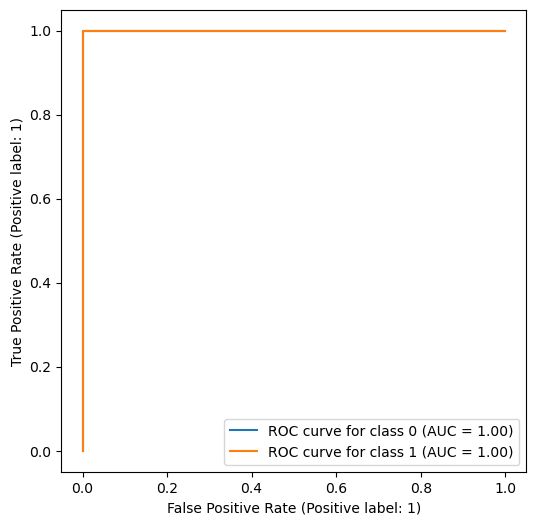

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
n_classes = 2

for class_id in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for class {class_id}",
        ax=ax,
        # plot_chance_level=(class_id == 2),
    )

In [20]:
print("Classification report:\n{}".format(classification_report(df_test[target_col], h2o.as_list(predictions["predict"]))))

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00        10

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


# LightGBM

In [21]:
config = {}
config["objective"] = "binary"

df_train_scaled_enc = df_train_scaled.copy()
df_valid_scaled_enc = df_valid_scaled.copy()
df_test_scaled_enc = df_test_scaled.copy()
lgb_cat_cols = cat_cols

label_encoder = LabelEncoder(lgb_cat_cols)
df_train_scaled_enc = label_encoder.fit_transform(df_train_scaled_enc)
df_valid_scaled_enc = label_encoder.transform(df_valid_scaled_enc)
df_test_scaled_enc = label_encoder.transform(df_test_scaled_enc)

lgbtrain = lgbm.Dataset(
    df_train_scaled_enc.drop(columns=[target_col] + id_cols),
    df_train_scaled_enc[target_col],
    categorical_feature=lgb_cat_cols,
    free_raw_data=False,
)
lgbvalid = lgbm.Dataset(
    df_valid_scaled_enc.drop(columns=[target_col] + id_cols),
    df_valid_scaled_enc[target_col],
    reference=lgbtrain,
    free_raw_data=False,
)
# Final TRAIN/TEST
ftrain = pd.concat([df_train_scaled_enc, df_valid_scaled_enc]).reset_index(drop=True)
flgbtrain = lgbm.Dataset(
    ftrain.drop(columns=[target_col] + id_cols),
    ftrain[target_col],
    categorical_feature=lgb_cat_cols,
    free_raw_data=False,
)
lgbtest = lgbm.Dataset(
    df_test_scaled_enc.drop(columns=[target_col] + id_cols),
    df_test_scaled_enc[target_col],
    categorical_feature=lgb_cat_cols,
    reference=flgbtrain,
    free_raw_data=False,
)

In [22]:
model = lgbm.train(
    config,
    lgbtrain,
    valid_sets=[lgbvalid],
    valid_names=[""],
    feval=None,
)

[LightGBM] [Info] Number of positive: 81, number of negative: 747
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 828, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097826 -> initscore=-2.221616
[LightGBM] [Info] Start training from score -2.221616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [23]:
res = predict_cls_lgbm_from_raw(
    preds_raw=model.predict(lgbtest.data, raw_score=True),
    task="binary",
) 

result = pd.DataFrame(
    {
        "predicted": res,
        "ground_truth": df_test[target_col].values,
    }
)

print("Classification report:\n{}".format(classification_report(result["ground_truth"], result["predicted"])))

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00        10

    accuracy                           1.00       104
   macro avg       1.00      1.00      1.00       104
weighted avg       1.00      1.00      1.00       104



In [24]:
y_onehot_test = pd.get_dummies(df_test_scaled[target_col]).values
y_score = predict_proba_lgbm_from_raw(
    preds_raw=model.predict(lgbtest.data),
    task="binary",
    binary2d=True,
)

micro_roc_auc_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    average=None,
)

micro_roc_auc_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    average="weighted",
)

print(f"Per class AUC:\n{micro_roc_auc_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_weighted}")

Per class AUC:
[1. 1.]
Weighted AUC:
1.0
